In [71]:
import numpy as np
import rasterio
import rasterio.mask
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch
import matplotlib as mpl
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

def transform_crs(dst_crs, resolution):

    input_paths = []
    output_paths = []

    # transition data
    for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
        input_paths.append(f"../data/raw/biomass/amazonia/{resolution}m/additional/" + f"mapbiomas-brazil-collection-70-amazonia-{year_start}_{year_end}.tif")
        output_paths.append(f"../data/interim/biomass/amazonia/{resolution}m/additional/" + f"transition_{year_start}_{year_end}.tif")

    for input_path, output_path in zip(input_paths, output_paths):
        with rasterio.open(input_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            with rasterio.open(output_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                    
# function to load biomass data
def load_biomass_data(year=None, year_end=None, folder="interim", shape=None, resolution=250, delta=None, name=None, additional=True):
    
    # determine the path to load from from
    if additional:
        path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/additional/" 
    else:
        path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/"
    if name is None:
        path_bio = path_bio + f"biomass_{year}.tif" if year_end is None else path_bio + f"transition_{year}_{year_end}.tif"
    else:
        path_bio = path_bio + name + ".tif"

    nodata = 255 if year_end is None else False

    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    bio_data = torch.from_numpy(bio_data)
    if delta is not None:
        diff_x = int((bio_data.shape[1]%delta)/2 + delta)
        diff_y = int((bio_data.shape[0]%delta)/2 + delta)
        bio_data = torch.nn.functional.pad(bio_data, (diff_y, diff_y, diff_x, diff_x), value=nodata)
    return bio_data, out_meta
                
# function to transform labels to 0=no-transition, 1=transition
def transform_transition_to_labels(transition_data):
    forest_labels = [1,3,4,5,49]
    deforestation_labels = [14,15,18,19,39,20,40,61,41,36,46,47,48,9,21,
                            22,23,24,30,25]
    transition_labels = []
    for forest_label in forest_labels:
        for deforestation_label in deforestation_labels:
            transition_labels.append(100*forest_label+deforestation_label)
    transition_data_new = np.zeros_like(transition_data, dtype=bool)
    for transition_label in transition_labels:
        transition_data_new[transition_data == transition_label] = True
    return transition_data_new

# function to transform labels to 0=forest, 1=natural, 2=farming, 3=urban, 4=water, 255=unknown
def transform_biodata_to_labels(bio_data):
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
                22:3,23:3,24:3,30:3,25:3, # urban
                26:4,33:4,31:4, # water
                27:255,0:255, 255:255} # unobserved
    bio_data_new = np.zeros_like(bio_data)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return bio_data_new

def preprocess_data(dst_crs, resolution):
    # will transform all data to target crs and save
    transform_crs(dst_crs, resolution)

    # preprocess transition data
    for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
        transition_data, out_meta = load_biomass_data(year_start, year_end)
        transition_data = transform_transition_to_labels(transition_data)
        with rasterio.open(f"../data/interim/biomass/amazonia/{resolution}m/additional/" + f"transition_{year_start}_{year_end}.tif", "w", **out_meta) as dest:
            dest.write(np.expand_dims(transition_data, axis=0))

In [72]:
dst_crs = 'EPSG:6933'
preprocess_data(dst_crs, 250)

# Calculate Deforestation rates

In [73]:
import geopandas as gpd
path = "../data/raw/biomass/Biomas_250mil/lm_bioma_250.shp"
df = gpd.read_file(path)
df['area_6933'] = df.geometry.to_crs("EPSG:6933").area / 10000

In [74]:
df

,Bioma,CD_Bioma,geometry,area_6933
0,Amazônia,1,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",4.215443e+08
1,Caatinga,2,"POLYGON ((-41.74080 -2.80826, -41.73673 -2.809...",8.626395e+07
2,Cerrado,3,"POLYGON ((-43.39009 -2.33937, -43.38741 -2.342...",1.984554e+08
3,Mata Atlântica,4,"MULTIPOLYGON (((-48.70814 -28.44851, -48.70994...",1.106845e+08
4,Pampa,5,"POLYGON ((-52.82472 -27.46295, -52.81558 -27.4...",1.939473e+07
5,Pantanal,6,"POLYGON ((-57.75946 -15.72779, -57.75659 -15.7...",1.509610e+07


In [75]:
df.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [76]:
bio_data_2010, _ = load_biomass_data(2010, additional=False)
transition_2005_2010, _ = load_biomass_data(2005, 2010, additional=False)
transition_2010_2015, _ = load_biomass_data(2010, 2015, additional=False)

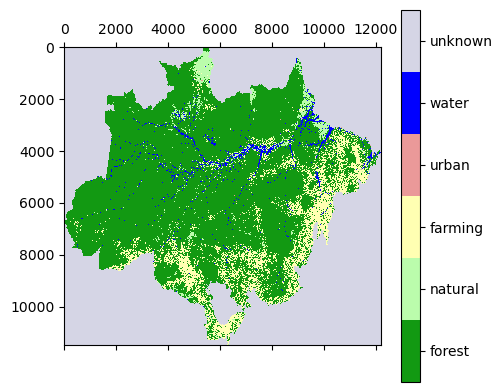

In [67]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data_2010,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

In [119]:
def load_raw_data(year_start, year_end=None, shape=None, resolution=250):
    path_bio = f"../data/raw/biomass/amazonia/{resolution}m/"
    path_bio = path_bio + f"mapbiomas-brazil-collection-70-amazonia-{year_start}.tif" if year_end is None else path_bio + f"additional/mapbiomas-brazil-collection-70-amazonia-{year_start}_{year_end}.tif"
    nodata = 255 if year_end is None else False
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    bio_data = torch.from_numpy(bio_data)
    return bio_data, out_meta
bio_data_2010_untransformed, _ = load_raw_data(2010, year_end=None, shape=df[df.Bioma == "Amazônia"].geometry, resolution=250)
bio_data_2010_untransformed = transform_biodata_to_labels(bio_data_2010_untransformed)

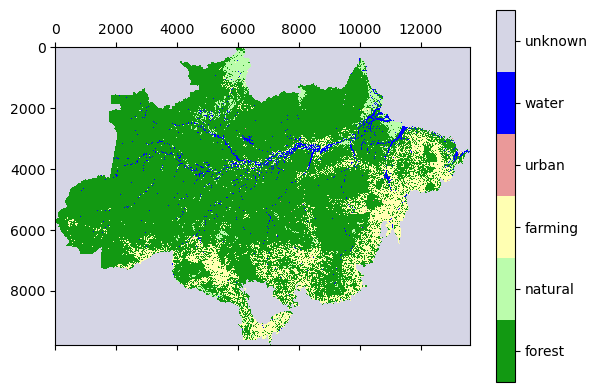

In [66]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data_2010_untransformed,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

In [122]:
observed_px = np.count_nonzero(bio_data_2010_untransformed != 255)
# area_amazonia = int(df[df.Bioma == "Amazônia"].area_6933)
area_amazonia = 4196943 * 100
adapted_px_dim_untransform = np.sqrt(area_amazonia * 10000 / observed_px)
print("Area [ha] - reported online: ", 4196943 * 100)
print("Area [ha] - 250m px: ", observed_px * 250**2 / 10000)
print("Adpated pixel dim: ", adapted_px_dim_untransform)

Area [ha] - reported online:  419694300
Area [ha] - 250m px:  427199893.75
Adpated pixel dim:  247.7941083176385


In [78]:
observed_px = np.count_nonzero(bio_data_2010 != 255)
area_amazonia = int(df[df.Bioma == "Amazônia"].area_6933)
adapted_px_dim = np.sqrt(area_amazonia * 10000 / observed_px)
print("Area [ha] - reported online: ", 4196943 * 100)
print("Area [ha] - EPSG:6933: ", area_amazonia)
print("Area [ha] - 250m px: ", observed_px * 250**2 / 10000)
print("Adpated pixel dim: ", adapted_px_dim)

Area [ha] - reported online:  419694300
Area [ha] - EPSG:6933:  421544315
Area [ha] - 250m px:  452349718.75
Adpated pixel dim:  241.33730835579587


In [125]:
deforestation_rate = []
for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
    transition_data, out_meta = load_biomass_data(year_start, year_end)
    deforestation_rate.append(torch.sum(transition_data) * adapted_px_dim**2 / 10000)

In [124]:
deforestation_rate_raw = []
for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
    transition_data, out_meta = load_raw_data(year_start, year_end)
    transition_data = transform_transition_to_labels(transition_data)
    deforestation_rate_raw.append(np.sum(transition_data) * adapted_px_dim_untransform**2 / 10000)

In [102]:
reported = [1658674.60, 1886757.99, 2569816.57, 2241427.52, 1856240.31, 1358708.47, 1040013.11, 969637.09, 531704.23, 463594.51, 547810.70,470476.73, 574083.73,544083.04,705946.23,895557.06,694287.44,792901.58,740159.18,710286.58]

In [130]:
import pandas as pd
deforestation_df_1 = pd.DataFrame({
    "year": np.arange(2001,2021),
    "deforestation [ha]": reported,
    "source": ["reported"] * len(reported)})
deforestation_df_2 = pd.DataFrame({
    "year": np.arange(2001,2021),
    "deforestation [ha]": deforestation_rate,
    "source": ["calculated"] * len(deforestation_rate)})
deforestation_df_3 = pd.DataFrame({
    "year": np.arange(2001,2021),
    "deforestation [ha]": deforestation_rate_raw,
    "source": ["no transform"] * len(deforestation_rate_raw)})
deforestation_df = pd.concat([deforestation_df_1, deforestation_df_2])

In [131]:
import plotly.express as px
fig = px.line(deforestation_df, x="year", y="deforestation [ha]", color="source", title="Deforestation in Amazonian Biome in year before")
fig.show()

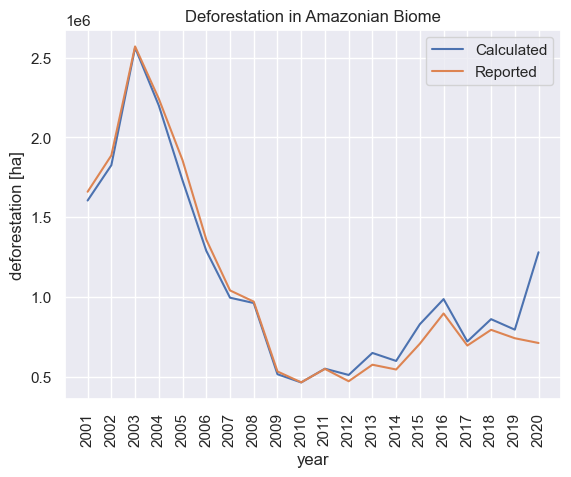

In [109]:
import seaborn as sns
sns.set_theme()

plt.plot(np.arange(2001,2021), deforestation_rate)
plt.plot(np.arange(2001,2021), reported)
plt.legend(['Calculated', 'Reported'])
plt.title("Deforestation in Amazonian Biome")
plt.ylabel("deforestation [ha]")
plt.xlabel("year")
plt.xticks(np.arange(2001,2021), np.arange(2001,2021))
plt.xticks(rotation=90)
plt.show()